In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def train_points_in_high_dim_repulsion(
    N=10, D=1024, lr=0.01, num_iterations=5000, alpha=1.0, beta=1.0
):
    X = torch.randn(N, D, requires_grad=True)
    optimizer = torch.optim.Adam([X], lr=lr)

    loss_radius_history = []
    loss_coulomb_history = []

    for step in range(num_iterations):
        optimizer.zero_grad()

        norms = torch.norm(X, dim=1)   # shape (N,)
        loss_radius = torch.sum((norms - 1.0)**2)

        loss_coulomb = 0.0
        for i in range(N):
            for j in range(i+1, N):
                dist_ij = torch.norm(X[i] - X[j])
                loss_coulomb += 1.0 / (dist_ij + 1e-9)

        loss = alpha * loss_radius + beta * loss_coulomb

        loss.backward()
        optimizer.step()

        loss_radius_history.append(loss_radius.item())
        loss_coulomb_history.append(loss_coulomb.item())

    X_final = X.detach().cpu()
    loss_dict = {
        "loss_radius": loss_radius_history,
        "loss_coulomb": loss_coulomb_history,
    }
    return X_final, loss_dict

def reduce_to_3d_by_pca(X_highdim):
    X_centered = X_highdim - np.mean(X_highdim, axis=0, keepdims=True)

    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    V_top3 = Vt[:3].T  # shape (D, 3)

    X_3d = np.dot(X_centered, V_top3)

    return X_3d

def plot_loss_curves(loss_dict):
    r_hist = loss_dict["loss_radius"]
    c_hist = loss_dict["loss_coulomb"]
    
    print(f"final radius loss: {r_hist[-1]}")
    print(f"final orthogonal loss: {c_hist[-1]}")

    plt.figure()
    plt.plot(r_hist, label="Radius Loss")
    plt.plot(c_hist, label="Coulomb Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss Value")
    plt.yscale('log')
    plt.title("Loss Curves (High-Dim)")
    plt.legend()
    plt.show()

def plot_3d_points_with_sphere(X_3d, angles=[0, 45, 90, 135]):
    radius = 1.0
    u = np.linspace(0, 2*np.pi, 30)
    v = np.linspace(0, np.pi, 15)
    u, v = np.meshgrid(u, v)
    x_sphere = radius * np.cos(u) * np.sin(v)
    y_sphere = radius * np.sin(u) * np.sin(v)
    z_sphere = radius * np.cos(v)

    for azim in angles:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')

        ax.plot_surface(
            x_sphere, y_sphere, z_sphere,
            color='gray', alpha=0.2
        )

        ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

        for i in range(X_3d.shape[0]):
            ax.plot(
                [0, X_3d[i,0]],
                [0, X_3d[i,1]],
                [0, X_3d[i,2]],
                color='red'
            )

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax._axis3don = False

        ax.view_init(elev=15, azim=azim)

        plt.title(f"Projected to 3D (azim={azim} deg)")
        plt.show()
        
def pairwise_distance_stats(pts: torch.Tensor):
    dist_mat = torch.cdist(pts, pts, p=2)  # (N,N)
    N = pts.shape[0]

    mask = torch.triu(torch.ones(N, N), diagonal=1).bool()
    pairwise_dists = dist_mat[mask]  # (N*(N-1)/2,)

    mean_pairwise_dist = pairwise_dists.mean()
    std_pairwise_dist = pairwise_dists.std()

    tdm_pairwise = torch.sum(torch.abs(pairwise_dists - mean_pairwise_dist))

    norms = torch.norm(pts, dim=1, p=2)
    mean_norm = norms.mean()
    std_norm = norms.std()

    tdm_norms = torch.sum(torch.abs(norms - mean_norm))

    return (pairwise_dists, mean_pairwise_dist, std_pairwise_dist, tdm_pairwise,
            norms, mean_norm, std_norm, tdm_norms)

final radius loss: 0.0021493379026651382
final orthogonal loss: 29.750757217407227


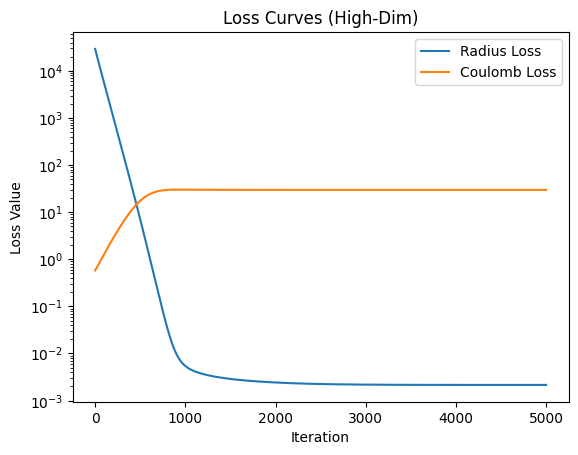

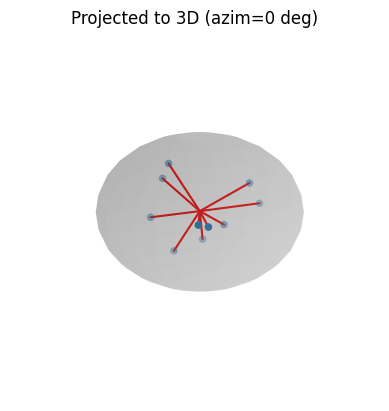

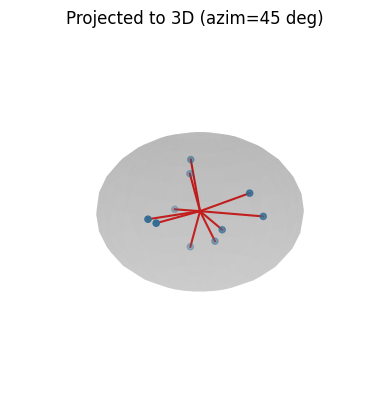

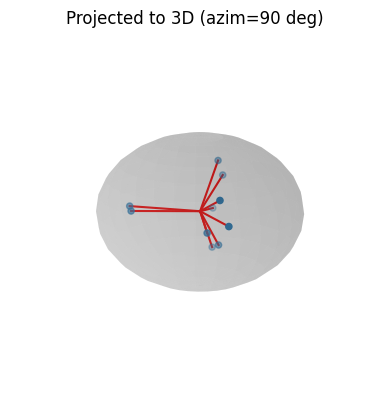

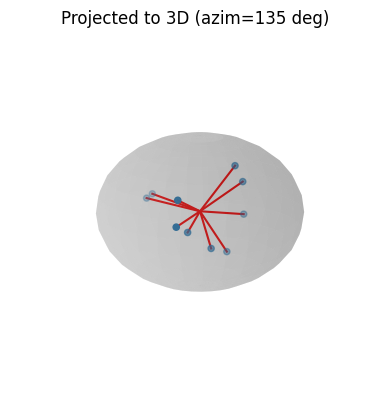

In [3]:
N = 10
D = 3 * 32 * 32
lr = 0.01
num_iterations = 5000
alpha = 100.0
beta = 1.0

X_highdim, loss_dict = train_points_in_high_dim_repulsion(
    N=N, D=D, lr=lr, num_iterations=num_iterations,
    alpha=alpha, beta=beta
)

plot_loss_curves(loss_dict)

X_3d = reduce_to_3d_by_pca(X_highdim.numpy())

plot_3d_points_with_sphere(X_3d, angles=[0, 45, 90, 135])

In [5]:
prior_means = X_highdim

radius = 0.01
prior_means_r = prior_means * radius

torch.save(prior_means_r, f"prior_mean_coulomb_{D}dim_{N}point_radius{radius}.pt")

(pairwise_dists, mean_pd, std_pd, tdm_pd,
    norms, mean_n, std_n, tdm_n) = pairwise_distance_stats(prior_means_r)

print(f"== {N}-prior in {D}-dim (Gaussian-Coulomb Optimization) ==")
print("Pairwise distances:", pairwise_dists)
print(f"Mean pairwise distance = {mean_pd:.6f}, Std = {std_pd:.6f}")
print(f"Total deviation from mean (pairwise) = {tdm_pd:.6f}")

print("\nDistance from origin:", norms)
print(f"Mean norm = {mean_n:.6f}, Std = {std_n:.6f}")
print(f"Total deviation from mean (norms) = {tdm_n:.6f}")

== 10-prior in 3072-dim (Gaussian-Coulomb Optimization) ==
Pairwise distances: tensor([0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151,
        0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151,
        0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151,
        0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151,
        0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151])
Mean pairwise distance = 0.015126, Std = 0.000000
Total deviation from mean (pairwise) = 0.000001

Distance from origin: tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101])
Mean norm = 0.010147, Std = 0.000000
Total deviation from mean (norms) = 0.000000
